# Load DataSet

In [ ]:
# imports 
import numpy as np
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D 
!pip install plot-keras-history -q
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
data = np.load('Data.npz')
print(data.files)

--2022-01-12 12:57:27--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  9.24MB/s    in 2.0s    

2022-01-12 12:57:31 (9.24 MB/s) - ‘Data.npz’ saved [19725078/19725078]

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


# Visualization

In [ ]:
import numpy as np

x_train = data['train_images']
y_train = data['train_labels']

x_val = data['val_images']
y_val = data['val_labels']

x_test = data['test_images']
y_test = data['test_labels']

print('Labels: ', np.unique(y_train))
labels_number = len(np.unique(y_train))

print('train_images shape: ', data['train_images'].shape)
print('train_labels shape: ', data['train_labels'].shape)

print('val_images shape: ', data['val_images'].shape)
print('val_labels shape: ', data['val_labels'].shape)

print('test_images shape: ', data['test_images'].shape)
print('test_labels shape: ', data['test_labels'].shape)

Labels:  [0 1 2 3 4 5 6]
train_images shape:  (7007, 28, 28, 3)
train_labels shape:  (7007, 1)
val_images shape:  (1003, 28, 28, 3)
val_labels shape:  (1003, 1)
test_images shape:  (2005, 28, 28, 3)
test_labels shape:  (2005, 1)


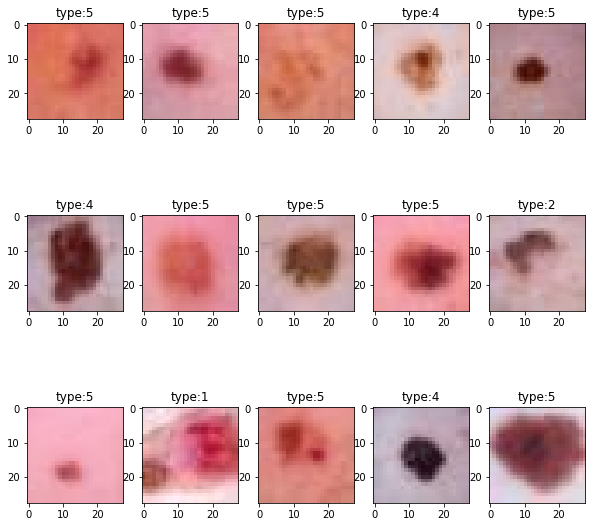

In [ ]:
def plot_img(x_train, y_train):
    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(10, 10))
    columns = 5
    rows = 3
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = x_train[i]
        plt.imshow(img)
        plt.title('type:'+str(y_train[i][0]))
    plt.show()
plot_img(x_train, y_train)

# Unbalancment of data 

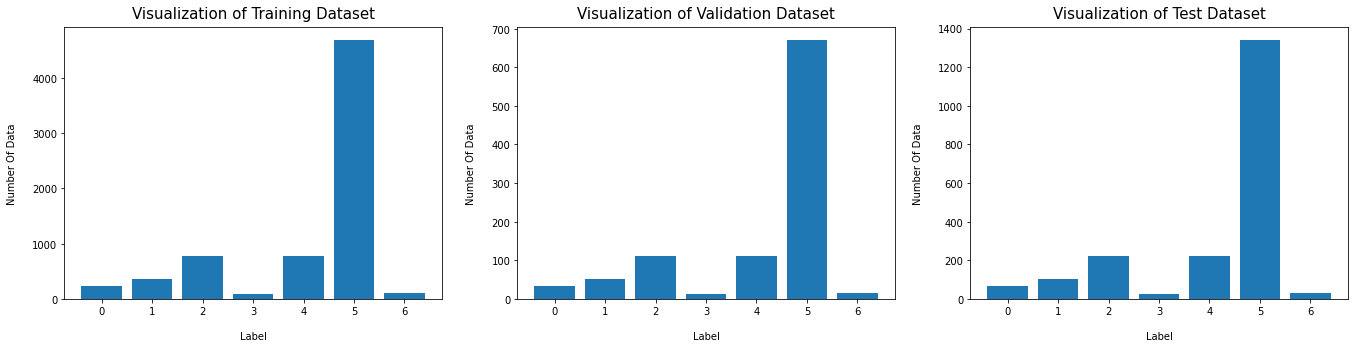

In [ ]:
from matplotlib import pyplot as plt

def data_summary(y):
    data = dict()
    for i in range(labels_number):
        data[str(i)] = (int)(np.sum(y==i))
    group_data = list(data.values())
    group_names = list(data.keys())
    return group_data, group_names

def draw_ax(i, group_data, group_names, title):
    ax[i].bar(group_names, group_data)
    ax[i].set_title("Visualization of "+ title , y=1.01, fontsize=15)
    ax[i].set_ylabel("Number Of Data", labelpad=15)
    ax[i].set_xlabel("Label", labelpad=15)

fig, ax = plt.subplots(1, 3, figsize=(23, 5))

group_data, group_names = data_summary(y_train)
draw_ax(0, group_data, group_names, "Training Dataset")

group_data, group_names = data_summary(y_val)
draw_ax(1, group_data, group_names, "Validation Dataset")

group_data, group_names = data_summary(y_test)
draw_ax(2, group_data, group_names, "Test Dataset")

# Preprocess

In [ ]:
import tensorflow
from tensorflow import keras

X_train = x_train / 255.0
X_val = x_val / 255.0
X_test = x_test / 255.0

Y_train = tensorflow.keras.utils.to_categorical(y_train, labels_number)
Y_val = tensorflow.keras.utils.to_categorical(y_val, labels_number)
Y_test = tensorflow.keras.utils.to_categorical(y_test, labels_number)
print(Y_train.shape)
print(X_train.shape)

(7007, 7)
(7007, 28, 28, 3)


# Model && Training

In [ ]:

# write your codes
def build_model():
    input_img = keras.Input(shape= X_train.shape[1:])
    conv1  = Conv2D(256, kernel_size=(3,3), padding='same', activation= 'relu')(input_img)
    conv2 =  Conv2D(128, kernel_size=(3,3), padding='same', activation= 'relu')(conv1)
    batch_norm1 = BatchNormalization()(conv2)
    max_pool1 = MaxPooling2D(pool_size=(2, 2))(batch_norm1)

    conv3 = Conv2D(128, kernel_size=(3,3), padding='same', activation= 'relu')(max_pool1)
    conv4 = Conv2D(128, kernel_size=(3,3), padding='same', activation= 'relu')(conv3)
    batch_norm2 = BatchNormalization()(conv4)
    max_pool2 = MaxPooling2D((2, 2))(batch_norm2)
    dropout1 =  Dropout(0.2)(max_pool2)

    conv5 = Conv2D(64, kernel_size=(3,3), padding='same', activation= 'relu')(dropout1)
    conv6 = Conv2D(64, kernel_size=(3,3), padding='same', activation= 'relu')(conv5)
    batch_norm3 = BatchNormalization()(conv6)
    max_pool3 = MaxPooling2D((2, 2))(batch_norm3)
    dropout2 = Dropout(0.3)(max_pool3)

    conv7 = Conv2D(32, kernel_size=(3,3), padding='same', activation= 'relu')(dropout2)
    conv8 = Conv2D(32, kernel_size=(3,3), padding='same', activation= 'relu')(conv7)
    conv9 = Conv2D(32, kernel_size=(3,3), padding='same', activation= 'relu')(conv8)
    batch_norm4 = BatchNormalization()(conv9)
    max_pool4 = MaxPooling2D((2, 2))(batch_norm4)
    dropout3 = Dropout(0.4)(max_pool4)

    flat = Flatten()(dropout3)
    dense1 = Dense(1024, activation= 'relu', kernel_initializer='he_uniform')(flat)
    batch_norm5 = BatchNormalization()(dense1)
    dense2 = Dense(512, activation= 'relu', kernel_initializer='he_uniform')(batch_norm5)
    dropout4 = Dropout(0.5)(dense2)
    output = Dense(7, activation="softmax")(dense2)

    model = Model(inputs=input_img, outputs=output)

    return model
    
model = build_model()
model.compile(optimizer= keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics= ['accuracy', ])
model.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 256)       7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
callback = keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/dermamnist.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, 
                    Y_train,
                    batch_size= 128,
                    epochs= 35,
                    validation_data= (X_val, Y_val),
                    callbacks=[callback])

Epoch 1/35
55/55 [==============================] - 7s 96ms/step - loss: 1.3221 - accuracy: 0.5991 - val_loss: 1.3373 - val_accuracy: 0.6690
Epoch 2/35
55/55 [==============================] - 5s 87ms/step - loss: 1.0186 - accuracy: 0.6468 - val_loss: 1.2792 - val_accuracy: 0.6680
Epoch 3/35
55/55 [==============================] - 5s 87ms/step - loss: 0.9482 - accuracy: 0.6623 - val_loss: 1.3846 - val_accuracy: 0.5015
Epoch 4/35
55/55 [==============================] - 5s 87ms/step - loss: 0.9186 - accuracy: 0.6730 - val_loss: 1.6466 - val_accuracy: 0.2333
Epoch 5/35
55/55 [==============================] - 5s 87ms/step - loss: 0.8970 - accuracy: 0.6787 - val_loss: 1.2493 - val_accuracy: 0.5872
Epoch 6/35
55/55 [==============================] - 5s 88ms/step - loss: 0.8681 - accuracy: 0.6907 - val_loss: 1.1649 - val_accuracy: 0.6062
Epoch 7/35
55/55 [==============================] - 5s 95ms/step - loss: 0.8587 - accuracy: 0.6919 - val_loss: 0.9635 - val_accuracy: 0.6919
Epoch 8/35
55

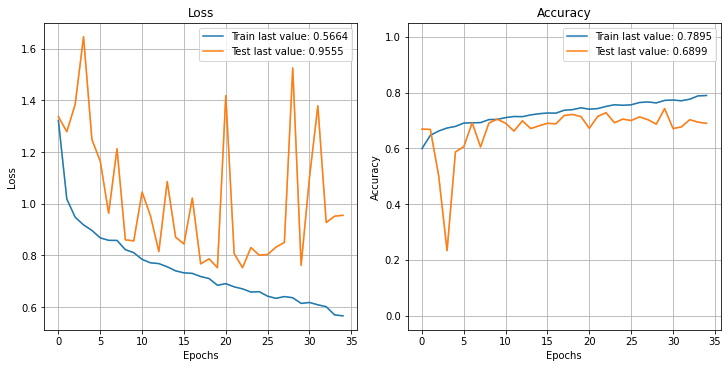

In [ ]:
from plot_keras_history import plot_history
plot_history(history)
plt.show()

# recall - precision - f1 score

load model from drive

In [ ]:
model = build_model()
model.compile(optimizer= keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics= ['accuracy', ])
model.load_weights('/content/drive/MyDrive/dermamnist.h5')

In [ ]:
# compute prediction of X_test
probabilitys = model.predict(X_test)

In [ ]:
# precesion & f1-score & recall for test data
y_pred = np.argmax(probabilitys , axis=1)
y_true = np.argmax(Y_test, axis=1)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.54      0.20      0.29        66
           1       0.34      0.43      0.38       103
           2       0.60      0.37      0.46       220
           3       0.00      0.00      0.00        23
           4       0.64      0.21      0.32       223
           5       0.81      0.96      0.88      1341
           6       0.49      0.72      0.58        29

    accuracy                           0.75      2005
   macro avg       0.49      0.41      0.42      2005
weighted avg       0.72      0.75      0.71      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Compute the precsision and recall of each class with python code.

In [ ]:
target_class = 3
f = np.argwhere(y_true == target_class)
f2 = y_pred[f]
f2 = f2.squeeze()

true_positive = sum(f2 == target_class)
positive_pred = np.argwhere(y_pred == target_class)
pos_pred = len(positive_pred)

print('ture_positive for class {} ===> {}'.format(target_class , true_positive))
print('ture_data for class {} ===> {}'.format(target_class , len(f)))
print('positive_prediction for class {} ===> {}'.format(target_class , pos_pred))
print()

precision = true_positive / pos_pred

recall = true_positive / len(f)

f1_score = 2 * (recall * precision) / (recall + precision)

print(np.round(precision, 2) , np.round(recall, 2), np.round(f1_score, 2))

ture_positive for class 3 ===> 0
ture_data for class 3 ===> 23
positive_prediction for class 3 ===> 0

nan 0.0 nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


# precision-recall(AUC)

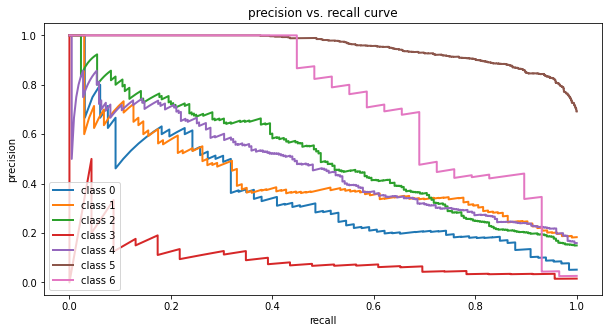

In [ ]:
precisions = dict()
recalls = dict()

plt.figure(figsize=(10, 5))
for i in range(labels_number):
    precisions[i], recalls[i], _ = precision_recall_curve(Y_test[:, i], probabilitys[:, i])
    plt.plot(recalls[i], precisions[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


# Confusion matrix


<Figure size 720x720 with 0 Axes>

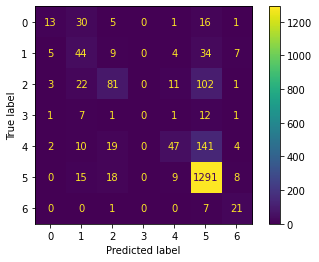

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, )

# bouns Section

In [ ]:
strategy = {0:228 * 8, 1:359 * 6, 2:769* 3, 3:80 * 25, 4:779 * 3, 5:4693, 6:99*20}

os = RandomOverSampler(sampling_strategy=strategy)
oversampled_X , oversampled_y = os.fit_resample(X_train.reshape(X_train.shape[0], -1), Y_train)

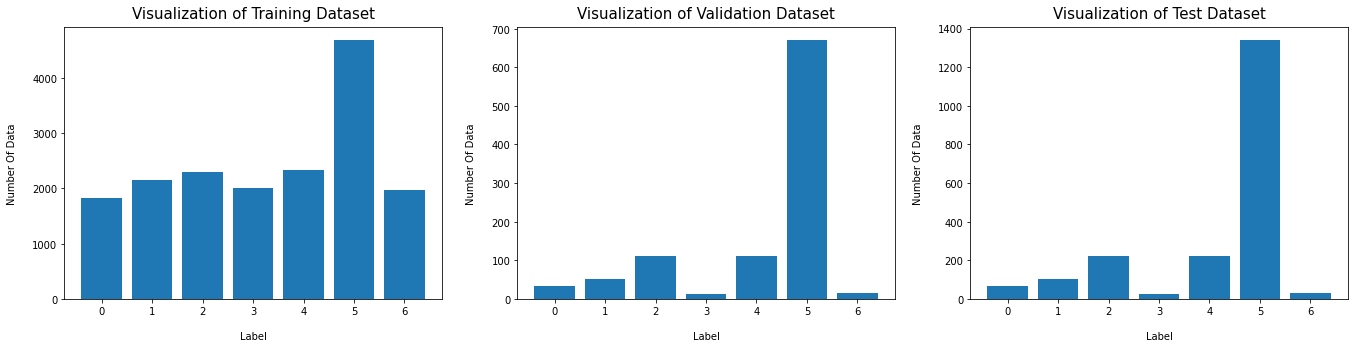

In [ ]:
x = oversampled_X.reshape((-1, 28, 28, 3))
y = np.argmax(oversampled_y, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(23, 5))

group_data1, group_names1 = data_summary(y)
draw_ax(0, group_data1, group_names1, "Training Dataset")

group_data, group_names = data_summary(y_val)
draw_ax(1, group_data, group_names, "Validation Dataset")

group_data, group_names = data_summary(y_test)
draw_ax(2, group_data, group_names, "Test Dataset")

In [ ]:
sec_model =  build_model()
sec_model.compile(optimizer= keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics= ['accuracy', ])

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='wrap')

generated_data = datagen.flow(x, oversampled_y, seed=42)

In [ ]:
history = sec_model.fit(generated_data.x, 
                    generated_data.y,
                    batch_size= 128,
                    epochs= 35,
                    validation_data= (X_val, Y_val))

Epoch 1/35
136/136 [==============================] - 13s 86ms/step - loss: 1.8229 - accuracy: 0.3372 - val_loss: 3.3172 - val_accuracy: 0.0259
Epoch 2/35
136/136 [==============================] - 11s 83ms/step - loss: 1.4072 - accuracy: 0.4515 - val_loss: 2.9828 - val_accuracy: 0.0578
Epoch 3/35
136/136 [==============================] - 11s 83ms/step - loss: 1.1812 - accuracy: 0.5370 - val_loss: 1.5143 - val_accuracy: 0.5314
Epoch 4/35
136/136 [==============================] - 11s 83ms/step - loss: 1.1314 - accuracy: 0.5684 - val_loss: 1.4253 - val_accuracy: 0.5085
Epoch 5/35
136/136 [==============================] - 11s 83ms/step - loss: 0.9072 - accuracy: 0.6520 - val_loss: 0.9792 - val_accuracy: 0.6371
Epoch 6/35
136/136 [==============================] - 11s 83ms/step - loss: 0.8387 - accuracy: 0.6832 - val_loss: 1.3507 - val_accuracy: 0.5543
Epoch 7/35
136/136 [==============================] - 11s 83ms/step - loss: 0.7170 - accuracy: 0.7277 - val_loss: 0.8805 - val_accuracy:

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48ae254d10>,
       dtype=object))

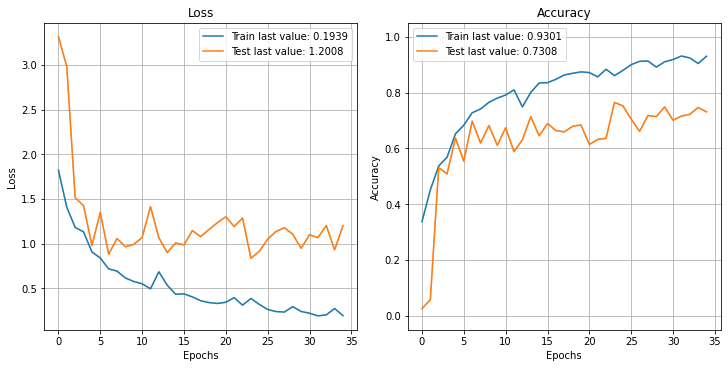

In [ ]:
from plot_keras_history import plot_history
plot_history(history)